# 目标 用python和numpy构建神经网络

Node
forward: function,how to calculate the inputs
backwards:Function,how to get the gradients when backprogogation
gradients:Mapper,the gradient map the node of its inputs node 
inputs:List,the input nodes of this node
outputs:List,the output node of this node

## 面向对象的方式组织

In [136]:
def add(a, b):
    return a +ｂ

In [137]:
var_int = 10
var_2_int = 10

In [138]:
add(var_int, var_2_int)

20

In [139]:
var_int = [100, 200]
var_2_int = [122, 122233, 1231]

In [140]:
add(var_int, var_2_int)

[100, 200, 122, 122233, 1231]

## 构建基类

In [301]:
class Node:
    """每个Node在神经网络中将有这属性attributes和函数方法methods"""
    def __init__(self,inputs=[]): #python里面添加s复数
        """if the node is the operator of "ax+b",the inputs will be x node, and the outputs of this is its sucessors
        and the value is *ax+b*
        """
        self.inputs = inputs 
       # self.outputs = outputs
        self.value = None
        self.outputs = []
        self.gradients = {} #是一个空字典
        
        for node in self.inputs:  
            node.outputs.append(self) # 建立一个链接关系
        
    def forward(self):
        """Forward propogation
        compute the output value based on input nodes and store the value into self.value
        """
        
        raise NotImplemented #是一个虚类,没有实现
    
    def backward(self):
        """Back propogation
        
        compute the gradient of each input node and store the value into "self.gredients" 
        """
        
        raise NotImplemented
        

In [302]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self,inputs=[])
        self.name= name
        
    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self] #n对于self的偏导
            self.gradients[self] = grad_cost #自己对自己的偏导
            
    def __repr__(self):
         return 'Input Node: {}'.format(self.name)

In [303]:
import numpy as np

In [304]:
X = np.array([1,2,3])

In [305]:
W = np.array([[1,2],[2,4],[3,5]])

In [306]:
X.shape

(3,)

In [307]:
W.shape

(3, 2)

In [308]:
B = np.array([1,3])

In [309]:
np.dot(X, W) + B

array([15, 28])

In [310]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs=[nodes, weights, bias])
    
    def forward(self):
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value
    
    def backward(self):
        
        for node in self.outputs:
            #gradient_cost = node.gradients[self] #gradient_cost是一个矩阵
            grad_cost = node.gradients[self]
            
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost) #加转置？？？
            self.gradients[self.b_node] = np.sum(grad_cost * 1,axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)

In [311]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        self.x_node = node
        
    def _sigmoid(self,x):
        return 1. / (1 + np.exp(-1 * x)) #sigmoid函数
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
        
    def backward(self):
        y = self.value
        
        self.partial = y * (1 - y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[self.x_node] = grad_cost * self.partial     

In [312]:
W1 = np.array([[1, 1], [1, 2], [1, 3]])
W2 = np.array([[1, 1], [0, 2], [1, 4]])

In [313]:
(W1.reshape(-1, 1) - W2.reshape(-1, 1)) ** 2

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1]], dtype=int32)

In [314]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true, y_hat])
    
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1,1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1,1)  #写成了reshaper
       
        self.diff = y_true_flatten - y_hat_flatten
        
        self.value = np.mean(self.diff**2)
    
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] = (-2 / n) * self.diff     

In [315]:
def training_one_batch(topological_sorted_graph):
    #graph 是经过拓扑排序之后的一个list
    for node in topological_sorted_graph:
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()

## 框架
def topological_sort():
    pass
  
def sgd_update():
    pass

from sklearn.datasets import load_boston
data = load_boston

In [316]:
def topological_sort(data_with_value):
    feed_dict = data_with_value
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in':set(), 'out':set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(),'out':set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
            
    L = []
    S = set(input_nodes)
    while len(S) >0:
        n = S.pop()
        
        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds
            
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L
            

In [317]:
def sgd_update(trainable_nodes, learning_rate=1e-2):   #1e-2????
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

In [318]:
from sklearn.datasets import load_boston

In [319]:
data = load_boston()

In [320]:
X_ = data['data']   

In [321]:
#help(load_boston) 查里面的每个维度

In [322]:
X

array([1, 2, 3])

In [323]:
y_ = data['target']

In [324]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [325]:
y_[0]

24.0

In [326]:
X_ =(X_ - np.mean(X_, axis=0)) / np.std(X_,axis=0)

In [327]:
n_features = X_.shape[1]

In [328]:
n_hidden = 10

In [329]:
n_hidden_2 = 10

In [330]:
X.shape

(3,)

In [331]:
#?np.random.randn # 生成标准正态分布

In [332]:
W1_, b1_ = np.random.randn(n_features,n_hidden), np.zeros(n_hidden)

In [333]:
#b1 = np.zeros(n_hidden) #可以分开写，也可以两行合并在一起

In [334]:
W2_, b2_ = np.random.randn(n_hidden,1), np.zeros(1)

In [335]:
#W1_, b1_ = np.random.randn(n_features, n_hidden),np.zeros(n_hidden)

In [336]:
#W2_, b2_ = np.random.randn(n_hidden, 1), np.zeros(1)

In [337]:
#b1 = np.zeros(n_hidden)

In [338]:
#W2 = np.random.randn(n_hidden, 1)

In [339]:
#b2 = np.zeros(1)

# Build a graph connection
## 1st.Build Nodes in this graph

In [340]:
X, y = Input(name='X'),Input(name='y') 
W1, b1 = Input('W1'), Input(name='b1')
W2, b2 = Input('W2'), Input(name='b2')

## 2nd build connection relationship

In [341]:
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

In [342]:
input_node_with_value = {
    X: X_,
    y: y_,
    W1: W1_,
    W2: W2_,
    b1: b1_,
    b2: b2_,
}

In [343]:
input_node_with_value = {  # -> feed_dict 
    X: X_, 
    y: y_, 
    W1: W1_, 
    W2: W2_, 
    b1: b1_, 
    b2: b2_
}

In [344]:
graph = topological_sort(input_node_with_value)

In [345]:
graph

[Input Node: X,
 Input Node: W1,
 Input Node: b2,
 Input Node: W2,
 Input Node: b1,
 Input Node: y,

In [346]:
from sklearn.utils import resample

In [347]:
np.random.choice(range(100), size=10, replace=True)

array([54, 50, 47, 59, 64, 71, 16, 61, 24, 27])

In [348]:
def run(dictionary):
    return topological_sort(dictionary)

In [349]:
losses = []
epochs = 5000

batch_size = 64

steps_per_epoch = X_.shape[0] // batch_size


for i in range(epochs):
    loss = 0
    
    for batch in range(steps_per_epoch):
        #indices = np.random.choice(range(X_.shape[0]), size=10, replace=True)
        #X_batch = X_[indices]
        #y_batch = y_[indices]
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        
        X.value = X_batch
        y.value = y_batch
        
#         input_node_with_value = {  # -> feed_dict 
#             X: X_batch, 
#             y: y_batch, 
#             W1: W1.value, 
#             W2: W2.value, 
#             b1: b1.value, 
#             b2: b2.value,
#         }
        
#         graph = topological_sort(input_node_with_value)
        
        training_one_batch(graph)
        
        learning_rate = 1e-3
        
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate=learning_rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss = 605.148
Epoch: 101, loss = 36.621
Epoch: 201, loss = 25.506
Epoch: 301, loss = 20.415
Epoch: 401, loss = 17.558
Epoch: 501, loss = 16.164
Epoch: 601, loss = 16.766
Epoch: 701, loss = 12.621
Epoch: 801, loss = 13.406
Epoch: 901, loss = 17.585
Epoch: 1001, loss = 12.682
Epoch: 1101, loss = 12.054
Epoch: 1201, loss = 12.078
Epoch: 1301, loss = 9.461
Epoch: 1401, loss = 13.730
Epoch: 1501, loss = 9.836
Epoch: 1601, loss = 9.716
Epoch: 1701, loss = 10.322
Epoch: 1801, loss = 7.831
Epoch: 1901, loss = 8.775
Epoch: 2001, loss = 8.155
Epoch: 2101, loss = 9.931
Epoch: 2201, loss = 10.466
Epoch: 2301, loss = 7.083
Epoch: 2401, loss = 13.768
Epoch: 2501, loss = 11.887
Epoch: 2601, loss = 7.427
Epoch: 2701, loss = 8.563
Epoch: 2801, loss = 8.477
Epoch: 2901, loss = 6.808
Epoch: 3001, loss = 8.833
Epoch: 3101, loss = 10.271
Epoch: 3201, loss = 8.665
Epoch: 3301, loss = 10.342
Epoch: 3401, loss = 8.553
Epoch: 3501, loss = 9.967
Epoch: 3601, loss = 9.031
Epoch: 3701, loss = 7.492
Epo

In [350]:
import matplotlib.pyplot as plt

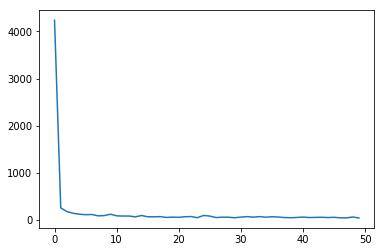

In [351]:
plt.plot(losses)

学习心得：夯实基础很重要，写程序5分钟，debug两天，血的教训！多谢李明晓老师的帮助，很多基础性的错误，这次错误在__inti_(少写了短横)，reshaper多了“r”，diff，少些了“i”，加油！视频中老师的代码也可能出错，以最后的版本为准！
AttributeError: 'numpy.ndarray' object has no attribute 'reshaper'
20190915于北京